# Regression with GAMs

In this notebook, we will fit regression GAMs in Python using the `statsmodels` library. In GAM models with no interactions, the model fitted are of the form

$$
Y(\mathbf{x}) = \alpha + f_1(x_1) + f_2(x_2) + \ldots + f_k(x_k) + \epsilon,
$$

where $f_i(\cdot), i = 1,\ldots,k$ are some non-parameteric functions


There are a few differences between the implementation in `statsmodels` and that in the `mgcv` package in R. 

- `mgcv` uses thin plate splines as the non-parameteric functions, while the `statsmodels` library does not have this functionality. Instead, we will be using B-splines. 
- The GAM implementation in `statsmodels` has verifiable support only for Gaussian and Poisson (count) regression. Support for binary classification is currently experimental and quite buggy.


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [2]:
plt.rcParams['figure.dpi'] = 150

As always, we will be using the `Concrete` dataset for demonstrating regression. There are a couple of differences in data storage and preprocessing from before:

1. We will directly supply pandas dataframes to the models, and won't create numpy ndarrays. Pandas DataFrames allow us to use the formula interface functionality in `statsmodels`.
2. For GAMs, we will **normalize the predictors** instead of standardizing them, i.e., scale each predictor to take values between 0 and 1.

In [3]:
# load the concrete dataset
crt = pd.read_csv("../data/concrete.csv")

# Normalizing the predictors
# NOTE: we will not drop the dataframe interface
# when using statsmodels
col_names = crt.drop('Strength',axis=1).columns
X_min,X_max = crt[col_names].min(),crt[col_names].max()
crt[col_names] = (crt[col_names]-X_min)/(X_max-X_min)

# standardize response
y_mean,y_std = crt['Strength'].mean(),crt['Strength'].std()
crt['Strength'] = (crt['Strength']-y_mean)/y_std
crt

,Cement,Slag,FlyAsh,Water,SPlast,CAgg,FAgg,Age,Strength
0,1.000000,0.000000,0.000000,0.321086,0.077640,0.694767,0.205720,0.074176,2.644123
1,1.000000,0.000000,0.000000,0.321086,0.077640,0.738372,0.205720,0.074176,1.560663
2,0.526256,0.396494,0.000000,0.848243,0.000000,0.380814,0.000000,0.739011,0.266498
3,0.526256,0.396494,0.000000,0.848243,0.000000,0.380814,0.000000,1.000000,0.313188
4,0.220548,0.368392,0.000000,0.560703,0.000000,0.515698,0.580783,0.986264,0.507732
...,...,...,...,...,...,...,...,...,...
1025,0.398174,0.322760,0.451274,0.461661,0.276398,0.200872,0.437280,0.074176,0.506535
1026,0.502740,0.000000,0.577711,0.592652,0.322981,0.049128,0.550426,0.074176,-0.277627
1027,0.106164,0.387869,0.542729,0.566294,0.189441,0.265698,0.466633,0.074176,-0.725377
1028,0.130365,0.519477,0.000000,0.429712,0.350932,0.548256,0.488961,0.074176,-0.182450


## (Univariate) B-spline regression

For a better understanding of the GAM model, we will first look at univariate B-splines. They are a special case of basis regression models. Basis regression models for an univariate input $x$ and an output $y$ are of the form:
$$
y = \beta_0 + \beta_1\phi_1(x) + \phi_2(x) + \ldots + \phi_p(x) + \epsilon,
$$

where $\phi_j(\cdot), j= 1,\ldots,p$ are basis functions. For example, the following code generates cubic B-spline (`degree=3`) basis functions for the predictor `Cement`. The number of basis functions is specified by the degrees of freedom (`df`).

In [4]:
from patsy import dmatrix

# create a b-spline representation for Cement
bs_concrete = dmatrix(
    'bs(Cement,df=3,degree=3)-1',
    data=crt,
    return_type='dataframe'
)
bs_concrete

,"bs(Cement, df=3, degree=3)[0]","bs(Cement, df=3, degree=3)[1]","bs(Cement, df=3, degree=3)[2]"
0,0.000000,0.000000,1.000000
1,0.000000,0.000000,1.000000
2,0.354328,0.393603,0.145744
3,0.354328,0.393603,0.145744
4,0.401979,0.113741,0.010728
...,...,...,...
1025,0.432650,0.286245,0.063127
1026,0.372934,0.377043,0.127066
1027,0.254458,0.030223,0.001197
1028,0.295772,0.044339,0.002216


These basis functions can then be used directly in a linear regression model. In the following code block, we will use the formula interface of `statsmodels` to fit a cubic B-spline regression model for `Strength` vs `Cement`. The equivalent R code is 

```{R}
library(splines)

spline_reg = lm(Strength~bs(Cement,df=3,degree=3),data=crt)
summary(spline_reg)
```

In [5]:
import statsmodels.api as sm

spline_reg = sm.OLS.from_formula(
    'Strength~bs(Cement,df=3,degree=3)',
    data=crt
).fit()
print(spline_reg.summary())

                            OLS Regression Results                            
Dep. Variable:               Strength   R-squared:                       0.248
Model:                            OLS   Adj. R-squared:                  0.246
Method:                 Least Squares   F-statistic:                     112.7
Date:                Wed, 01 Mar 2023   Prob (F-statistic):           4.28e-63
Time:                        11:06:46   Log-Likelihood:                -1314.3
No. Observations:                1030   AIC:                             2637.
Df Residuals:                    1026   BIC:                             2656.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept     

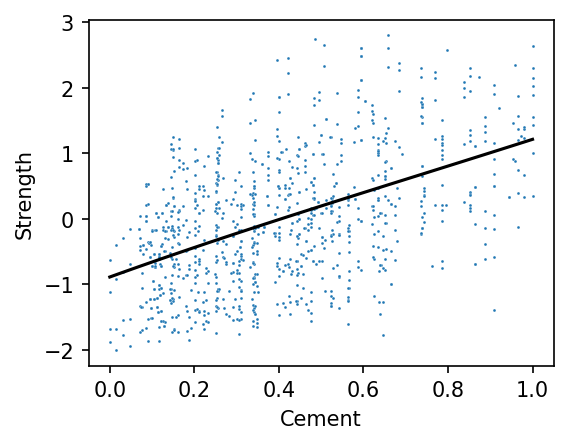

In [6]:
newdata = pd.DataFrame({
    'Cement':np.linspace(0,1,100)
})

# original data
fig,ax = plt.subplots(1,1,figsize=(4,3))
_ = sns.scatterplot(
    x='Cement',
    y='Strength',
    data=crt,
    ax=ax,
    s=2
)

# plot predictions
_ = ax.plot(newdata['Cement'],spline_reg.predict(newdata) , 'k-',)

There are two parameters that specify the basis for B-splines.

- degree. Common choice is `degree=3`. 
- df. For B-splines, this is the number of basis functions. This is the equivalent of the argument `k` in `mgcv::s`. 

Higher the number of basis functions, more is the flexibility of the model. In the following code block, we fit B-splines with different degrees of freedom. Notice that the "wiggliness" of the prediction curve increases with increasing df. The curve is smoother with smaller degresss of freedom - the curvature does not change much.
With 32 degrees of freedom, the model seems to be overfitting.

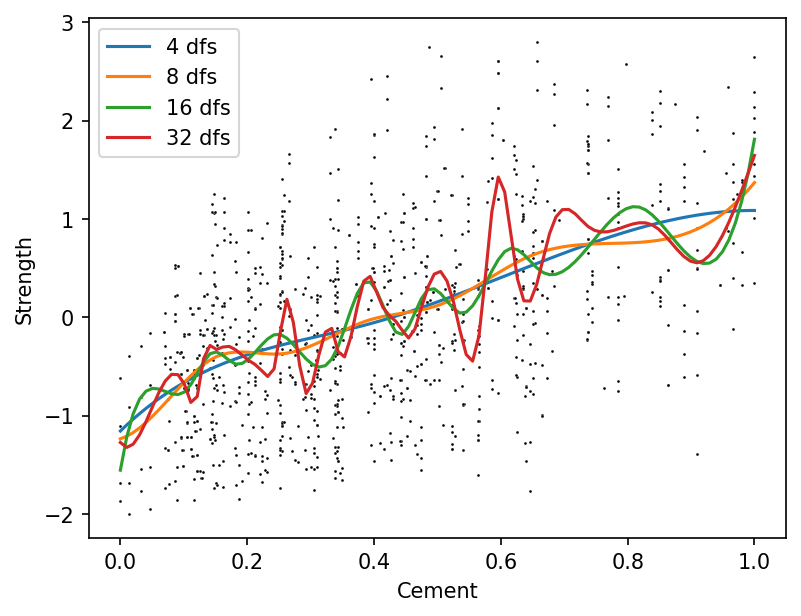

In [7]:
newdata = pd.DataFrame({
    'Cement':np.linspace(0,1,100)
})

# Testing different degrees of freedom
fig,ax = plt.subplots(1,1,figsize=(6,4.5))

_ = sns.scatterplot(
    x='Cement',
    y='Strength',
    data=crt,
    ax=ax,
    s=2,color='k'
)

spline_reg = [None]*4

for i,df in enumerate([4,8,16,32]):
    spline_reg[i] = sm.OLS.from_formula(
        'Strength~bs(Cement,df=%d,degree=3)'%df,
        data=crt
    ).fit()
    
    # plot predictions
    _ = ax.plot(newdata['Cement'],spline_reg[i].predict(newdata) , '-',label='%d dfs'%df)

_ = ax.legend(loc='best')

Let's repeat the above procedure for `Water` in place of `Cement`. Which model (degrees of freedom) do you think is reasonable?

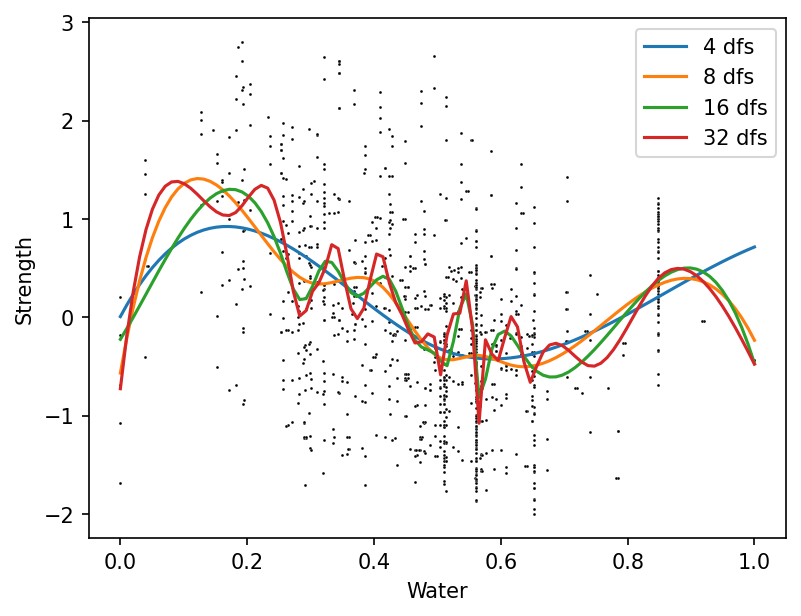

In [8]:
newdata = pd.DataFrame({
    'Water':np.linspace(0,1,100)
})

# Testing different degrees of freedom
fig,ax = plt.subplots(1,1,figsize=(6,4.5))

_ = sns.scatterplot(
    x='Water',
    y='Strength',
    data=crt,
    ax=ax,
    s=2,color='k'
)

spline_reg = [None]*4

for i,df in enumerate([4,8,16,32]):
    spline_reg[i] = sm.OLS.from_formula(
        'Strength~bs(Water,df=%d,degree=3)'%df,
        data=crt
    ).fit()
    
    # plot predictions
    _ = ax.plot(newdata['Water'],spline_reg[i].predict(newdata) , '-',label='%d dfs'%df)

_ = ax.legend(loc='best')

## Smoothing splines

There is an alternate method, to control the smoothness of the response - penalizing changes in curvature. The amount of penalty would we controlled by a smoothing penalty parameter. Higher the value of this parameter, the smoother is the prediction.

We will be using the `GLMGam` interface to fit a *univariate* smoothing spline regression model. In the univariate setting, GAMs with spline functions are equivalent to smoothing spline regression. There are four steps involved:

1. Create a B-spline representation of the input using `BSplines`.
2. Fit a GAM model with some initial guess for the smoothing parameter. 
3. Determine the optimal smoothing penalty parameter using **generalized cross-validation (GCV)**, AIC or some other criteria
4. Fit the final model with this optimal smoothing penalty parameter.

In the following code block, we are are fitting a spline regression model with 16 basis functions and no smoothing penalty. This is the same as earlier.

In [9]:
from statsmodels.gam.api import GLMGam, BSplines

# create a Bspline representation for Cement
bs_cement= BSplines(
    crt[['Cement']], 
    df=[16], 
    degree =[3],
    knot_kwds=[{'lower_bound':0.,'upper_bound':1.}]
)

smooth_spline = GLMGam.from_formula(
    'Strength ~ 1',
    data=crt,
    smoother=bs_cement, # smoothing terms go here
    alpha = 0 # smoothing penalty parameter - no penaly here
)

# initial fit with no smoothing penalties
sm_spline0 = smooth_spline.fit()

print(sm_spline0.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:               Strength   No. Observations:                 1030
Model:                         GLMGam   Df Residuals:                  1014.00
Model Family:                Gaussian   Df Model:                        15.00
Link Function:               identity   Scale:                         0.73208
Method:                         PIRLS   Log-Likelihood:                -1292.8
Date:                Wed, 01 Mar 2023   Deviance:                       742.33
Time:                        11:10:15   Pearson chi2:                     742.
No. Iterations:                     3   Pseudo R-squ. (CS):             0.3163
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -1.5626      0.376     -4.152      0.0

To determine the optimal value of `alpha`, we will use the `.select_penweight` method. There are three different criterion - `'aic'` (default), `'gcv'`, and `'bic'`. We will be using the `'gcv'` criteria, since this is the default option in the `mgcv` package in R.

In [10]:
# find the smoothing penalties via GCV
# can get different results each time, depending on initialization
alpha = smooth_spline.select_penweight(criterion='gcv')[0]
alpha

array([5.24456898e+10])

In [11]:
sm_spline = GLMGam.from_formula(
    'Strength ~ 1',
    data=crt,
    smoother=bs_cement,
    alpha = alpha
).fit()
print(sm_spline.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:               Strength   No. Observations:                 1030
Model:                         GLMGam   Df Residuals:                  1028.00
Model Family:                Gaussian   Df Model:                         1.00
Link Function:               identity   Scale:                         0.75290
Method:                         PIRLS   Log-Likelihood:                -1314.3
Date:                Wed, 01 Mar 2023   Deviance:                       773.98
Time:                        11:10:49   Pearson chi2:                     774.
No. Iterations:                     3   Pseudo R-squ. (CS):             0.2803
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.8497      0.054    -15.856      0.0

We now compare the unpenalized model with the penalized version. Even though we have specified the same degrees of freedom for both, the penalized model is a lot smoother. 

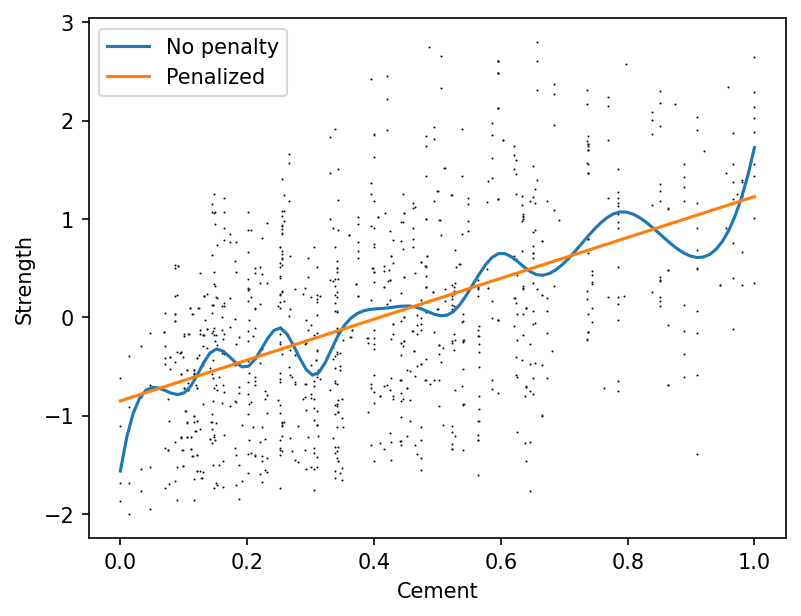

In [12]:
newdata = pd.DataFrame({
    'Cement':np.linspace(0,1,100)
})

fig,ax = plt.subplots(1,1,figsize=(6,4.5))

_ = sns.scatterplot(
    x='Cement',
    y='Strength',
    data=crt,
    ax=ax,
    s=1,color='k'
)

pred_nopenalty = sm_spline0.predict(newdata,newdata)
pred_penalized = sm_spline.predict(newdata,newdata)

_ = ax.plot(newdata['Cement'],pred_nopenalty , '-',label='No penalty')
_ = ax.plot(newdata['Cement'],pred_penalized , '-',label='Penalized')
_ = ax.legend(loc='best')

# GAM Regression

We will now fit a GAM model using all the predictors. The procedure again consists of the same 4 steps. Note that estimating the smoothing penalties via the GCV criterion is much more computationally expensive. Also, it is somehat sensitive to initialization - we can get different results in different runs.

In [13]:
from statsmodels.gam.api import GLMGam, BSplines

In [14]:
X = crt.drop('Strength',axis=1)
n_col = X.shape[1]

# create a Bspline representation for all columns
bs_conc= BSplines(
    X,
    df=[12]*n_col,
    degree =[3]*n_col,
    knot_kwds=[{'lower_bound':0.,'upper_bound':1.} for _ in range(n_col)]
)

# Gam with no smoothing penalties
gam_bs = GLMGam.from_formula(
    'Strength ~ 1', 
    data=crt,
    smoother=bs_conc,
    alpha=0
)

# initial fit
_ = gam_bs.fit()

# find smoothing penalities via GCV
# NOTE:  this can be a computationally expensive step
alpha = gam_bs.select_penweight(
    criterion='gcv', # criterion
    start_params= np.zeros(n_col),
    method='nm', # optimization method - 'Nelder Mead' is a global optimization method
)[0]

# fit the final gamma model with the appropriate smoothing penalties
gam_final = GLMGam.from_formula(
    'Strength ~ 1', 
    data=crt,
    smoother=bs_conc,
    alpha=alpha
).fit()

print(gam_final.summary())

Optimization terminated successfully.
         Current function value: 0.117173
         Iterations: 74
         Function evaluations: 237
                 Generalized Linear Model Regression Results                  
Dep. Variable:               Strength   No. Observations:                 1030
Model:                         GLMGam   Df Residuals:                   954.13
Model Family:                Gaussian   Df Model:                        74.87
Link Function:               identity   Scale:                         0.10055
Method:                         PIRLS   Log-Likelihood:                -239.11
Date:                Wed, 01 Mar 2023   Deviance:                       95.940
Time:                        11:12:13   Pearson chi2:                     95.9
No. Iterations:                     3   Pseudo R-squ. (CS):             0.9999
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025     

### Plotting the smoothed components

To plot the smoothed components for each feature, we will use the `.plot_partial` method.

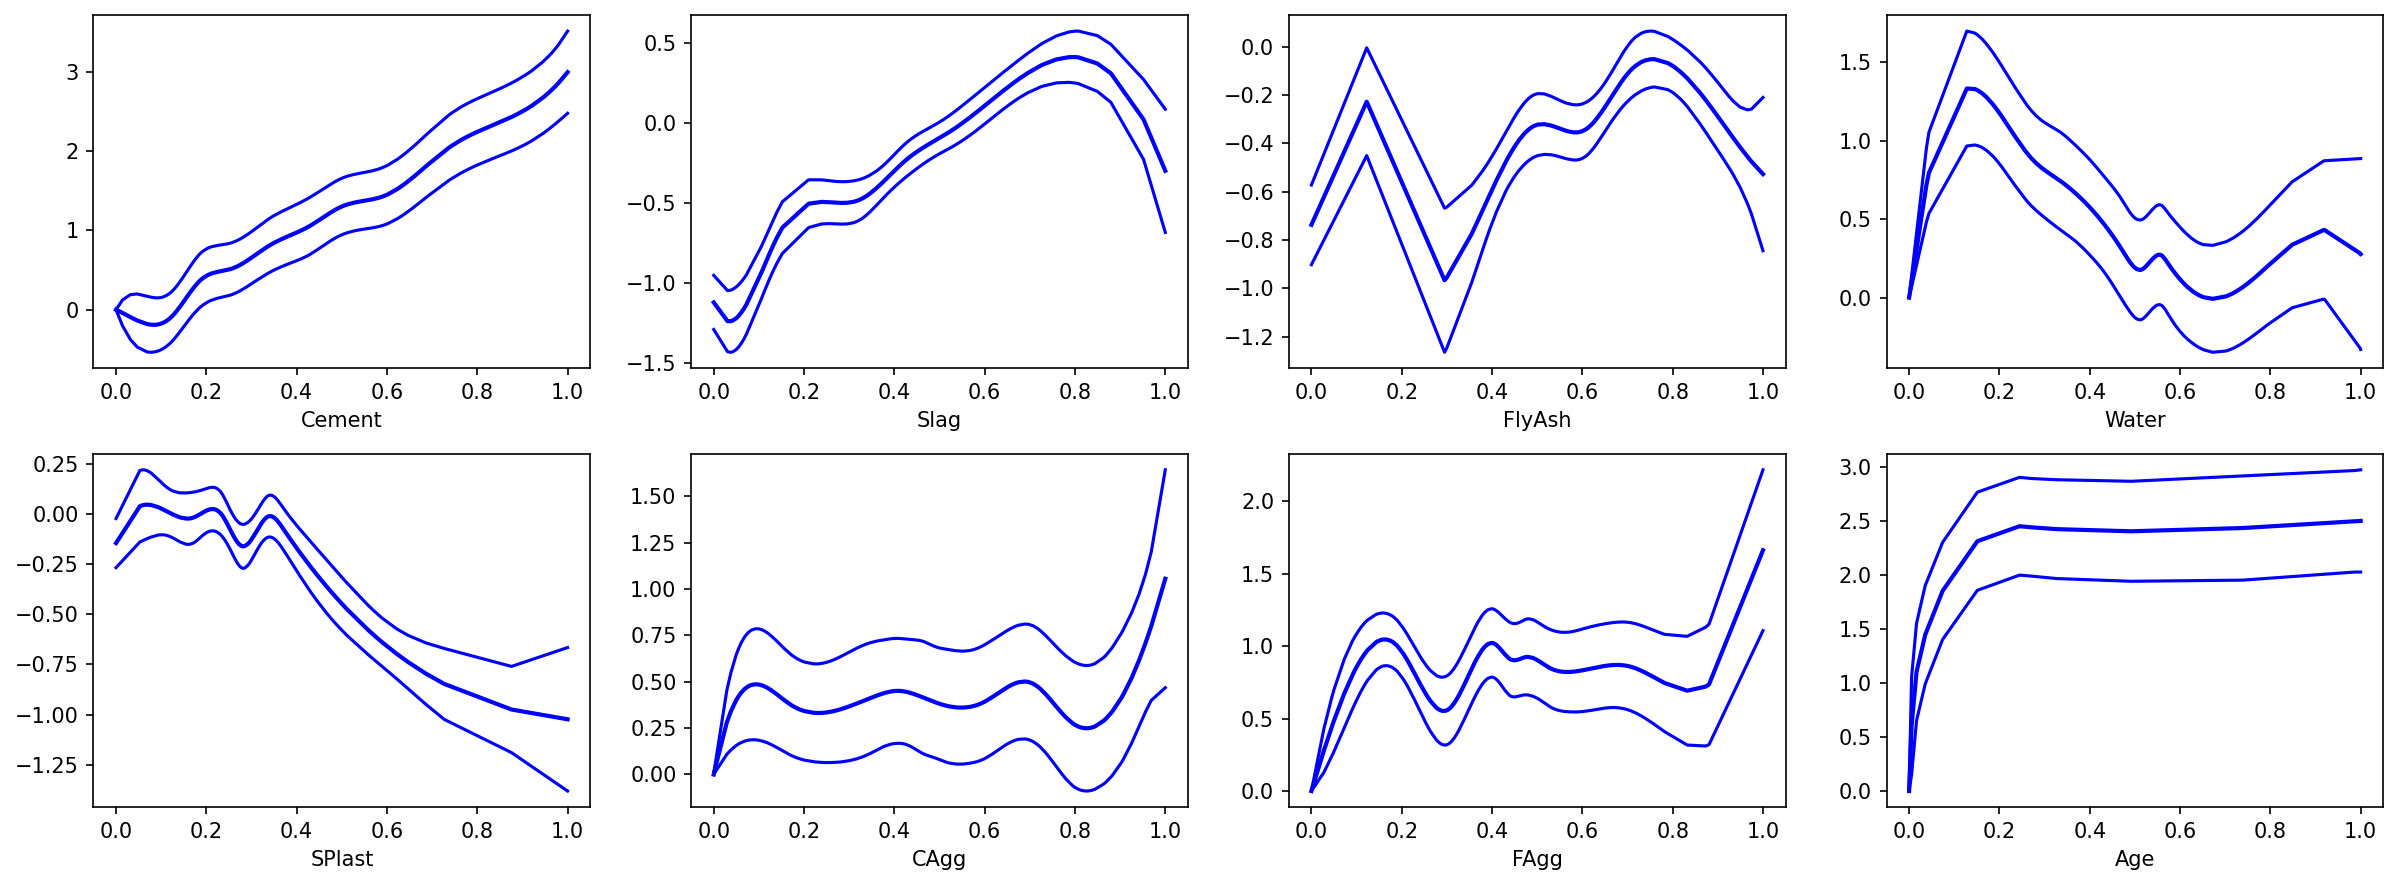

In [15]:
num_rows=2
num_cols=4
fig,axs = plt.subplots(num_rows,num_cols,figsize=(16,6))
for i in range(num_rows):
    for j in range(num_cols):
        # select correct feature
        feature_idx = num_cols*i + j
        
        # plot the smoothed component
        _ = gam_final.plot_partial(
            smooth_index = feature_idx, # index of the column
            plot_se = True,
            cpr = False,
            include_constant = False,
            ax=axs[i,j]
        )

fig.tight_layout()

**Exercise**:
Among all the 8 predictors, identify the 3 most important predictors.


### Performance metrics

In [16]:
# training r2
err = crt['Strength'] - gam_final.fittedvalues

train_r2 = 1-np.mean(err**2)/crt['Strength'].var()

print('Training R2: %5.3f'%train_r2 )

Training R2: 0.907


Like always, we will assess the generalization performance of the model using replicated K-fold CV. There are a couple of things to note for GAMs:

1. We need to create a separate B-spline representation for each training split. DO NOT USE THE REPRESENTATION CREATED ON THE ENTIRE DATASET.
2. We can **significantly** speed things up by simply using the `alpha` parameters estimated earlier on, instead of re-estimating them from scratch for each training split.

In [17]:
from sklearn.model_selection import RepeatedKFold
from sklearn.metrics import mean_squared_error

np.random.seed(1234)


# 5 replicates of 5-fold CV
n_folds = 5
n_repeats=5
rkf = RepeatedKFold(n_splits=n_folds,n_repeats=n_repeats)
mses_rkf = np.empty(n_folds*n_repeats)

for i,(train_index,test_index) in enumerate(rkf.split(crt)):
    # create B-spline representation for each training split
    bs_fold = BSplines(
        X.loc[train_index,:], 
        df=[12]*n_col, 
        degree =[3]*n_col,
        knot_kwds=[{'lower_bound':0.,'upper_bound':1.} for _ in range(n_col)]
    )
    
    # fit GAM model (with smoothing penalties found earlier)
    gam_fold = GLMGam.from_formula(
        'Strength ~ 1', 
        data=crt.loc[train_index,:],
        smoother=bs_fold,
        alpha=alpha
    ).fit()

    # compute test predictions
    y_pred = gam_fold.predict(
        exog=crt.loc[test_index,:], # to extract linear terms in the model
                                    # here, only the intercept term
        exog_smooth = X.loc[test_index,:] # for spline terms
    )
    # compute metric-mean-squared error
    mses_rkf[i] = mean_squared_error(crt['Strength'][test_index],y_pred)

mse_cv = mses_rkf.mean()

r2_cv = 1-mse_cv/crt['Strength'].var()

print('CV R2.....: %5.3f'%r2_cv)

CV R2.....: 0.885


For reference,

    CV R2 for neural network.....: 0.914
    CV R2 for regression tree....: 0.797
    CV R2 for linear regression..: 0.605
    
### Skipping smoothing for some features

For some features, we might not want to use smoothing terms:

1. The feature is categorical. Smoothing/interpolation is meaningless.
2. The feature is discrete, with very few unique values (say <10)
3. There is prior knowledge about the functional dependency of a feature. .E.g.: linear, quadratic, etc

To include linear terms of these features in the model, specify them in the formula. We will now use linear terms for the features `Cement` and `Slag`. The model fitted is of the form

$$
\beta_0 + \beta_\mathrm{Cement}\mathrm{Cement} + \beta_\mathrm{Slag}\mathrm{Slag} + \mathrm{smoothing\;terms}
$$

In [18]:
# exclude Cement and Slag from smoothing
X = crt.drop(['Strength','Cement','Slag'],axis=1)
n_col = X.shape[1]

# create a Bspline representation for all columns
bs_conc= BSplines(
    X,
    df=[12]*n_col, 
    degree =[3]*n_col,
    knot_kwds=[{'lower_bound':0.,'upper_bound':1.} for _ in range(n_col)]
)

# Gam with no smoothing penalties
gam_bs_new = GLMGam.from_formula(
    'Strength ~ Cement + Slag', 
    data=crt,
    smoother=bs_conc,
    alpha=0
)

# initial fit with no smoothing penalties
_ = gam_bs_new.fit()

# find smoothing penalities via GCV
# NOTE: Computationally expensive step. Takes a while to run
alpha_new = gam_bs_new.select_penweight(
    criterion='gcv', # criterion
    start_params= np.zeros(n_col),
    method='nm'
)[0]


# fit the final gamma model with the appropriate smoothing penalties
gam_final_new = GLMGam.from_formula(
    'Strength ~ Cement + Slag', 
    data=crt,
    smoother=bs_conc,
    alpha=alpha_new
).fit()

print(gam_final_new.summary())

Optimization terminated successfully.
         Current function value: 0.123114
         Iterations: 79
         Function evaluations: 193
                 Generalized Linear Model Regression Results                  
Dep. Variable:               Strength   No. Observations:                 1030
Model:                         GLMGam   Df Residuals:                   970.00
Model Family:                Gaussian   Df Model:                        59.00
Link Function:               identity   Scale:                         0.10919
Method:                         PIRLS   Log-Likelihood:                -290.07
Date:                Wed, 01 Mar 2023   Deviance:                       105.92
Time:                        11:15:45   Pearson chi2:                     106.
No. Iterations:                     3   Pseudo R-squ. (CS):             0.9997
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025     

In the summary, we can see that the coeffients for both `Cement`and `Slag` are significant.

We will now compute the training and cross-validation $R^2$ for this model.

In [19]:
# training r2
err = crt['Strength'] - gam_final_new.fittedvalues

train_r2 = 1-np.mean(err**2)/crt['Strength'].var()

print('Training R2: %5.3f'%train_r2 )

Training R2: 0.897


In [20]:
np.random.seed(1234)


# 5 replicates of K-fold CV
n_folds = 5
n_repeats=5
rkf = RepeatedKFold(n_splits=n_folds,n_repeats=n_repeats)
mses_rkf = np.empty(n_folds*n_repeats)

for i,(train_index,test_index) in enumerate(rkf.split(crt)):
    # create B-spline representation for the training set
    bs_fold = BSplines(
        X.loc[train_index,:], 
        df=[12]*n_col, 
        degree =[3]*n_col,
        knot_kwds=[{'lower_bound':0.,'upper_bound':1.} for _ in range(n_col)]
    )
    
    # fit GAM model (with smoothing penalties found earlier)
    gam_fold = GLMGam.from_formula(
        'Strength ~ Cement+Slag', 
        data=crt.loc[train_index,:],
        smoother=bs_fold,
        alpha=alpha_new
    ).fit()

    # compute test predictions
    y_pred = gam_fold.predict(
        exog=crt.loc[test_index,:], # to extract linear terms in the model,
        exog_smooth = X.loc[test_index,:] # 
    )
    # compute metric-mean-squared error
    mses_rkf[i] = mean_squared_error(crt['Strength'][test_index],y_pred)

mse_cv_new = mses_rkf.mean()

r2_cv_new = 1-mse_cv/crt['Strength'].var()

print('CV R2.....: %5.3f'%r2_cv)

CV R2.....: 0.885
